In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import vectorbt.optimizer.gridsearch as grids

# data

In [2]:
from importlib import reload
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 5)
from matplotlib import pyplot as plt

In [7]:
ohlc_df = vbt.data.load_cryptopair('USDT_BCH', vbt.data.ago_dt(days=180), vbt.data.now_dt(), period=vbt.data.Period.D1)

done. 0.33s


In [8]:
rate_sr = ohlc_df.O

In [18]:
fees = 0.0025
slippage_factor = 0.25
slippage = (ohlc_df['H'] - ohlc_df['L']) * slippage_factor / rate_sr

   count        mean        std    min         25%    50%      75%  \
O  107.0  618.707827  350.94529  297.9  377.671259  530.0  629.625   

           max  
O  1717.031055  


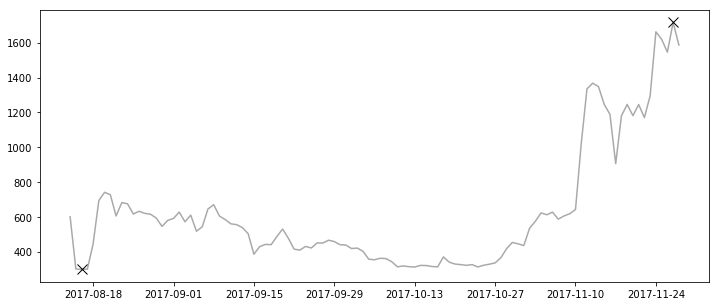

In [19]:
vbt.graphics.plot_line(rate_sr)

# number of positions

In [ ]:
param_range = list(range(2, 100)) * 100

In [20]:
def random_returns_func(n):
    pos_sr = vbt.positions.random(rate_sr, n)
    equity_sr = vbt.equity.from_positions(rate_sr, pos_sr, fees, slippage)
    returns_sr = vbt.returns.from_equity(equity_sr)
    return returns_sr

In [21]:
random_returns_srmap = grids.srmap.from_func(random_returns_func, param_range)

cores: 4
processes: 1
starmap: False
calcs: 9800 (~28.79s) ..
done. 14.23s


In [22]:
random_profit_nummap = grids.nummap.from_srmap(random_returns_srmap, vbt.performance.profit)

cores: 4
processes: 1
starmap: False
calcs: 98 (~0.21s) ..
done. 0.06s
min 92: -0.991910138533
max 15: 2.64190724742


     count      mean      std       min       25%       50%       75%     max
50%   98.0 -0.265274  0.60074 -0.943084 -0.847081 -0.395848  0.284516  2.1507


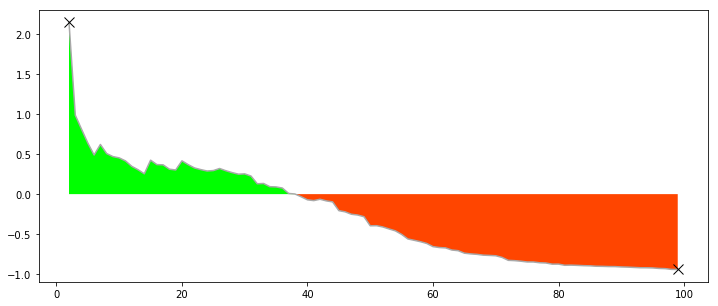

In [48]:
random_nummap_desc = random_profit_nummap.groupby(random_profit_nummap.index).describe()
vbt.graphics.plot_line(random_nummap_desc['50%'].rolling(window=30, min_periods=1).mean(), 0)

# MA crossover, cross-validated

In [28]:
ma_func = lambda window: vbt.indicators.EMA(rate_sr, window)
min_ma, max_ma, step = 1, 100, 1
N = 5
slices = grids.params.slices(rate_sr, N)

param_range = grids.params.range_params(min_ma, max_ma, step)
mamap = grids.srmap.from_func(ma_func, param_range)

param_space = grids.params.combine_rep_params(min_ma, max_ma, step, 2)
param_space = grids.params.multiply(list(range(len(slices))), param_space)

cores: 4
processes: 1
starmap: False
calcs: 100 (~0.07s) ..
done. 0.04s


In [35]:
# Func
def ma_returns_func(slice_idx, fast_ma, slow_ma):
    # Precalculation
    sliced_rate_sr = rate_sr.iloc[slices[slice_idx]]
    fast_ma_sr = mamap[fast_ma].iloc[slices[slice_idx]]
    slow_ma_sr = mamap[slow_ma].iloc[slices[slice_idx]]
    
    entries = vbt.signals.DMAC_entries(fast_ma_sr, slow_ma_sr)
    entries = vbt.bitvector.first(entries)
    exits = vbt.signals.DMAC_exits(fast_ma_sr, slow_ma_sr)
    exits = vbt.bitvector.first(exits)
    
    pos_sr = vbt.positions.from_signals(rate_sr, entries, exits)
    equity_sr = vbt.equity.from_positions(sliced_rate_sr, pos_sr, fees, slippage)
    returns_sr = vbt.returns.from_equity(equity_sr)
    return returns_sr

In [36]:
ma_returns_srmap = grids.srmap.from_func(ma_returns_func, param_space)

cores: 4
processes: 1
starmap: True
calcs: 25250 (~85.65s) ..
done. 42.16s


In [37]:
ma_nummap = grids.nummap.from_srmap(ma_returns_srmap, vbt.performance.profit)

cores: 4
processes: 1
starmap: False
calcs: 25250 (~23.07s) ..
done. 10.81s
min (0, 1, 6): -0.412461426311
max (0, 2, 4): 0.145226551745


In [43]:
ma_nummap_desc = ma_nummap.groupby(list(zip(*ma_nummap.index))[1:]).describe()
ma_matrix = grids.matrix.from_nummap(ma_nummap_desc['std'], symmetric=True).fillna(0)

done. 1.40s


     count     mean      std  min  25%  50%  75%       max
0  10000.0  0.00274  0.01669  0.0  0.0  0.0  0.0  0.184458


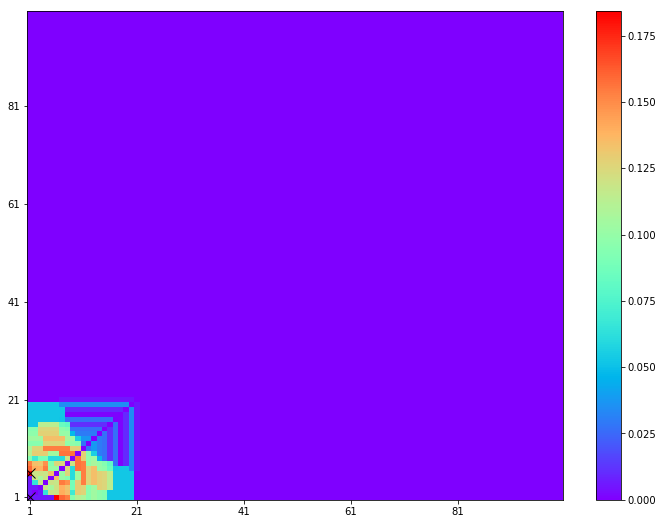

In [44]:
cmap = plt.cm.rainbow
norm = plt.Normalize()
matplotlib.rcParams['figure.figsize'] = (12, 9)
grids.matrix.plot(ma_matrix_df, cmap, norm)
matplotlib.rcParams['figure.figsize'] = (12, 5)